In [1]:
import scipy.sparse as sp
from g2g.model import Graph2Gauss
from g2g.utils import load_dataset, score_link_prediction, score_node_classification

### Load dataset

In [35]:
g = load_dataset('data/cora_ml.npz')
A, X, z = g['A'], g['X'], g['z']

In [40]:
import networkx as nx
import pandas as pd
from sklearn.preprocessing import StandardScaler
def load_data(edgelist_filename, features_filename, labels_filename, scale=False):

    graph = nx.read_weighted_edgelist(edgelist_filename, delimiter="\t", nodetype=int,
        create_using=nx.DiGraph() )

    zero_weight_edges = [(u, v) for u, v, w in graph.edges(data="weight") if w == 0.]
    print ("removing", len(zero_weight_edges), "edges with 0. weight")
    graph.remove_edges_from(zero_weight_edges)

    print ("ensuring all weights are positive")
    nx.set_edge_attributes(graph, name="weight", values={edge: abs(weight) 
        for edge, weight in nx.get_edge_attributes(graph, name="weight").items()})

    print ("number of nodes: {}\nnumber of edges: {}\n".format(len(graph), len(graph.edges())))

    if features_filename is not None:

        print ("loading features from {}".format(features_filename))

        if features_filename.endswith(".csv"):
            features = pd.read_csv(features_filename, index_col=0, sep=",")
            features = features.reindex(sorted(graph.nodes())).values
            if scale:
                features = StandardScaler().fit_transform(features) # input features are standard scaled
        else:
            raise Exception

        print ("features shape is {}\n".format(features.shape))

    else: 
        features = None

    if labels_filename is not None:

        print ("loading labels from {}".format(labels_filename))

        if labels_filename.endswith(".csv"):
            labels = pd.read_csv(labels_filename, index_col=0, sep=",")
            labels = labels.reindex(sorted(graph.nodes())).values.astype(int)#.flatten()
            assert len(labels.shape) == 2
        elif labels_filename.endswith(".pkl"):
            with open(labels_filename, "rb") as f:
                labels = pkl.load(f)
            labels = np.array([labels[n] for n in sorted(graph.nodes())], dtype=np.int)
        else:
            raise Exception

        print ("labels shape is {}\n".format(labels.shape))

    else:
        labels = None

    return graph, features, labels

In [41]:
import os
dir_ = os.path.join("..", "aheat", "datasets", "cora_ml")
graph, features, labels = load_data(os.path.join(dir_, "edgelist.tsv"),
                                   os.path.join(dir_, "feats.csv"),
                                   os.path.join(dir_, "labels.csv"))

removing 0 edges with 0. weight
ensuring all weights are positive
number of nodes: 2995
number of edges: 8416

loading features from ../aheat/datasets/cora_ml/feats.csv
features shape is (2995, 2879)

loading labels from ../aheat/datasets/cora_ml/labels.csv
labels shape is (2995, 1)



In [43]:
from scipy.sparse import csr_matrix

In [55]:
A = nx.adjacency_matrix(graph, nodelist=sorted(graph))
X = csr_matrix(features)
z = labels.flatten()

### Train a model and evaluate the link prediction performance

In [56]:
g2g = Graph2Gauss(A=A, X=X, L=2, K=3, verbose=True, p_val=0.0, p_test=0.0, p_nodes=0)
sess = g2g.train()

epoch:   0, loss: 0.9981
epoch:  50, loss: 0.6483
epoch: 100, loss: 0.5556
epoch: 150, loss: 0.5266
epoch: 200, loss: 0.5135
epoch: 250, loss: 0.5008
epoch: 300, loss: 0.5003
epoch: 350, loss: 0.4949
epoch: 400, loss: 0.4906
epoch: 450, loss: 0.4947
epoch: 500, loss: 0.4908
epoch: 550, loss: 0.4898
epoch: 600, loss: 0.4856
epoch: 650, loss: 0.4903
epoch: 700, loss: 0.4849
epoch: 750, loss: 0.4819


In [51]:
mu = g2g.mu.eval(session=sess)

In [63]:
os.makedirs("embeddings/cora_ml")

In [52]:
sigma = g2g.sigma.eval(session=sess)

In [57]:
mu2 = g2g.mu.eval(session=sess)

In [59]:
import numpy as np

In [53]:
import matplotlib.pyplot as plt

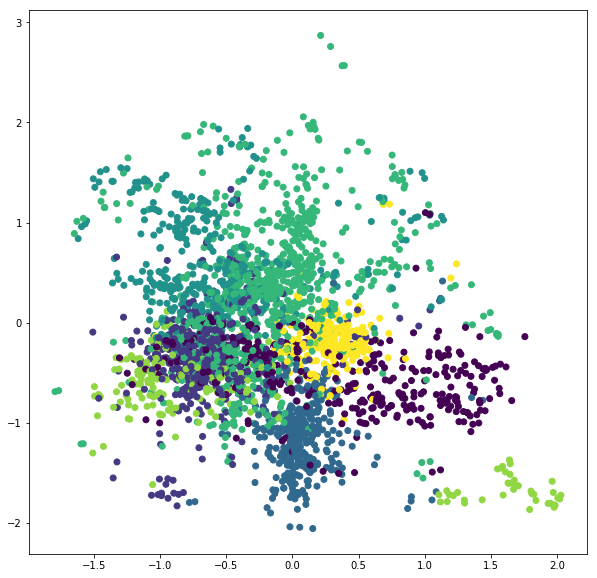

In [54]:
plt.figure(figsize=[10, 10])
plt.scatter(mu[:,0], mu[:,1], c=z)

In [4]:
test_auc, test_ap = score_link_prediction(g2g.test_ground_truth, sess.run(g2g.neg_test_energy))
print('test_auc: {:.4f}, test_ap: {:.4f}'.format(test_auc, test_ap))

test_auc: 0.9753, test_ap: 0.9766


### Train another model and evaluate the node classification performance

In [5]:
g2g = Graph2Gauss(A=A, X=X, L=64, verbose=True, p_val=0.0, p_test=0.00)
sess = g2g.train()
mu, sigma = sess.run([g2g.mu, g2g.sigma])

epoch:   0, loss: 0.9581
epoch:  50, loss: 0.2532
epoch: 100, loss: 0.1707
epoch: 150, loss: 0.1432
epoch: 200, loss: 0.1384
epoch: 250, loss: 0.1321
epoch: 300, loss: 0.1275
epoch: 350, loss: 0.1302
epoch: 400, loss: 0.1254
epoch: 450, loss: 0.1268
epoch: 500, loss: 0.1207
epoch: 550, loss: 0.1256
epoch: 600, loss: 0.1228
epoch: 650, loss: 0.1175
epoch: 700, loss: 0.1209


In [6]:
f1_micro, f1_macro = score_node_classification(mu, z, n_repeat=1, norm=True)
print('f1_micro: {:.4f}, f1_macro: {:.4f}'.format(f1_micro, f1_macro))

f1_micro: 0.8342, f1_macro: 0.8221


### Train another model without the node attributes X

In [7]:
g2g = Graph2Gauss(A=A, X=A+sp.eye(A.shape[0]), L=64, verbose=True, p_val=0.0, p_test=0.00)
sess = g2g.train()
mu, sigma = sess.run([g2g.mu, g2g.sigma])

epoch:   0, loss: 0.8757
epoch:  50, loss: 0.2358
epoch: 100, loss: 0.1548
epoch: 150, loss: 0.1341
epoch: 200, loss: 0.1299
epoch: 250, loss: 0.1244
epoch: 300, loss: 0.1193
epoch: 350, loss: 0.1239


In [8]:
f1_micro, f1_macro = score_node_classification(mu, z, n_repeat=1, norm=True)
print('f1_micro: {:.4f}, f1_macro: {:.4f}'.format(f1_micro, f1_macro))

f1_micro: 0.7804, f1_macro: 0.7626
